In [1]:
from sklearn import linear_model
import numpy as np
import os

import xarray as xr
import matplotlib.pyplot as plt

In [2]:
StepSize = 10 # how many output steps to predict over

In [3]:
DIR = '/data/oceans_output/open/racfur'
exp_list = ['4500yr_Windx0.50']
file_list =[]
for exp in exp_list:
    for filename in os.listdir(os.path.join(DIR,exp)):
        if filename.__contains__('cat'):
            file_list.append(os.path.join(DIR,exp,filename))

print(file_list)

FileNotFoundError: [Errno 2] No such file or directory: '/data/oceans_output/open/racfur/4500yr_Windx0.50'

In [4]:
file_list = ['/Users/brookspaige/Downloads/state.0000000000.t001.nc.gz']

In [5]:
#print(file_list[0])
ds   = xr.open_dataset(file_list[0])

In [25]:
# plt.plot(ds.Temp.values[:,0,0,0]);
list(zip(ds.Temp.dims, ds.Temp.shape))

[('T', 2841), ('Z', 42), ('Y', 78), ('X', 11)]

In [30]:
ds.Temp.values[:,z_level,lat,lon]

array([29.627897, 29.627945, 29.627525, ..., 29.627796, 29.627802,
       29.6278  ], dtype=float32)

In [43]:
ds.Temp.coords

Coordinates:
  * T        (T) float64 0.0 2.592e+06 5.184e+06 ... 7.359e+09 7.361e+09
  * Y        (Y) float64 -59.5 -58.48 -57.44 -56.36 ... 58.48 59.5 60.5 61.5
  * Z        (Z) float64 -5.0 -15.05 -25.25 ... -4.375e+03 -4.625e+03 -4.875e+03
  * X        (X) float64 1.0 3.0 5.0 7.0 9.0 11.0 13.0 15.0 17.0 19.0 21.0

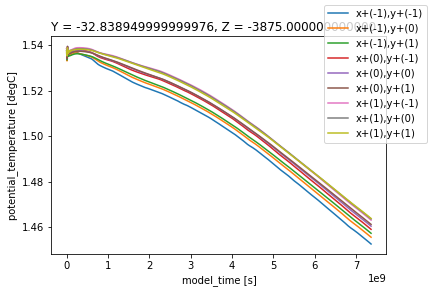

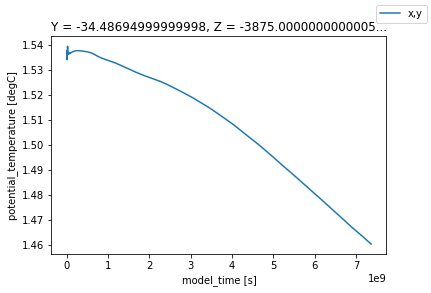

In [49]:
#Plot a timeseries of the various potential inputs 
# here plotting for a single grid cell. Plotting Temp for set grid point and 
# an 8 cell halo. Aim is to use this to predict Temp at a later time step

z_level=np.random.randint(30, 42-1)
lat=np.random.randint(1, 78-1)  # actually x point (11 points in x dir)
lon=np.random.randint(1, 11-1)  # actually y point (78 points in y dir)

fig1 = plt.figure()

for x_offset in (-1,0,1):
    for y_offset in (-1,0,1):
        ds.Temp.isel(X=lon+x_offset,Y=lat+y_offset,Z=z_level).plot(label=('x+(%d),y+(%d)' % (x_offset, y_offset)))

# ds.Temp.isel(X=lat-1,Y=lon+1,Z=z_level  ).plot(label=('x-1,y+1'))
# ds.Temp.isel(X=lat  ,Y=lon+1,Z=z_level  ).plot(label=('x  ,y+1'))
# ds.Temp.isel(X=lat+1,Y=lon+1,Z=z_level  ).plot(label=('x+1,y+1'))
# ds.Temp.isel(X=lat-1,Y=lon  ,Z=z_level  ).plot(label=('x-1,y  '))
# ds.Temp.isel(X=lat  ,Y=lon  ,Z=z_level  ).plot(label=('x  ,y  '))
# ds.Temp.isel(X=lat+1,Y=lon  ,Z=z_level  ).plot(label=('x+1,y  '))
# ds.Temp.isel(X=lat-1,Y=lon-1,Z=z_level  ).plot(label=('x-1,y-1'))
# ds.Temp.isel(X=lat  ,Y=lon-1,Z=z_level  ).plot(label=('x  ,y-1'))
# ds.Temp.isel(X=lat+1,Y=lon-1,Z=z_level  ).plot(label=('x+1,y-1'))

fig1.legend()

fig2 = plt.figure()
ds.Temp.isel(X=lon,Y=lat,Z=z_level).plot(label=('x,y'))
fig2.legend()

In [61]:
# ds.Temp.values[np.arange(0, len(ds.T.data)-StepSize, 40),
ds.Temp.shape

(2841, 42, 78, 11)

In [63]:
ds.Temp.isel(X=11,Y=0,Z=0,T=200).values

IndexError: index 11 is out of bounds for axis 0 with size 11

In [121]:
inputs = []
outputs = []

#just look at surface for now
for z in (0, 10, 20, 30):
    for x in range(0,10,3):
        for y in range(1,77,3):
            for time in range(0, len(ds.T.data)-StepSize, 40):
                inputs.append([ds.Temp.isel(T=time,X=x-1,Y=y+1,Z=z),
                               ds.Temp.isel(T=time,X=x  ,Y=y+1,Z=z),
                               ds.Temp.isel(T=time,X=x+1,Y=y+1,Z=z),
                               ds.Temp.isel(T=time,X=x-1,Y=y  ,Z=z),
                               ds.Temp.isel(T=time,X=x  ,Y=y  ,Z=z),
                               ds.Temp.isel(T=time,X=x+1,Y=y  ,Z=z),
                               ds.Temp.isel(T=time,X=x-1,Y=y-1,Z=z),
                               ds.Temp.isel(T=time,X=x  ,Y=y-1,Z=z),
                               ds.Temp.isel(T=time,X=x+1,Y=y-1,Z=z)])
                outputs.append([ds.Temp.isel(T=time+StepSize,X=x,Y=y,Z=z)])
    
inputs=np.asarray(inputs)
outputs=np.asarray(outputs)

inputs_keep=inputs
outputs_keep=outputs

print(inputs.shape)
print(outputs.shape)

(29536, 9)
(29536, 1)


In [122]:
#Split data into training and test data
split_ind = 4000 # change this to something based on model time eventually
inputs_tr, inputs_te = np.array(inputs[:split_ind, :]), np.array(inputs[split_ind:, :])
outputs_tr, outputs_te = np.array(outputs[:split_ind]), np.array(outputs[split_ind:])

print(inputs_tr.shape, inputs_te.shape)
print(outputs_tr.shape, outputs_te.shape)

(4000, 9) (25536, 9)
(4000, 1) (25536, 1)


In [123]:
### Normalise (based on training data only)
def normalise_data(train,test):
    train_mean, train_std = np.mean(train), np.std(train)
    train = (train - train_mean) / train_std
    test  = (test - train_mean) / train_std
    return train, test

# Calc mean and std for re-forming predictions
outputs_tr_mean = np.mean(outputs)
outputs_tr_std = np.std(outputs)
print(outputs_tr_mean, outputs_tr_std)

# normalise the data
outputs_tr[:], outputs_te[:] = normalise_data(outputs_tr[:], outputs_te[:])
for i in range(3):
    inputs_tr[:, i], inputs_te[:, i] = normalise_data(inputs_tr[:, i], inputs_te[:, i])

9.305326 8.034805


In [124]:
outputs_tr.squeeze().shape

(4000,)

In [125]:
# Fit a model....

model= linear_model.Lasso(alpha=0.1, fit_intercept=True)
# model = linear_model.LinearRegression(fit_intercept=False)

model.fit(inputs_tr, outputs_tr.squeeze() - inputs_tr[:,5])

/Users/brookspaige/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [126]:
print(model.coef_.round(2))
print(model.intercept_)

[ 0.   -0.   -0.    0.   -0.56 -0.33 -0.   -0.   -0.  ]
-1.900281


In [127]:
predict = model.predict((np.array([[35,35,35,35,35,35,35,35,35]]) - outputs_tr_mean)/outputs_tr_std)
print(predict*outputs_tr_std + outputs_tr_mean)

# predict = model.predict([[1,1,1,1,1,1,1,1,1]])
# print(predict)

[-28.79418361]


In [13]:
# how to evaluate test stats....?
model.score(inputs_te, outputs_te)  

0.9998531915142492

In [119]:
inputs[0]

array([-0.48248574, -2.0022283 , -2.0152004 ,  1.4568299 ,  1.377074  ,
        1.4297892 ,  1.4006513 ,  1.3343674 ,  1.3935673 ], dtype=float32)

In [120]:
inputs_tr[0]

array([-0.48248574, -2.0022283 , -2.0152004 ,  1.4568299 ,  1.377074  ,
        1.4297892 ,  1.4006513 ,  1.3343674 ,  1.3935673 ], dtype=float32)